In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
from time import time
from pandas.plotting import register_matplotlib_converters
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#link of the data : https://www.kaggle.com/datasets/prasoonkottarathil/btcinusd?select=BTC-2021min.csv
df = pd.read_csv("./Desktop/BTC-2021min.csv")

df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

df_hourly = df.resample('1H').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last'})

df

,unix,symbol,open,high,low,close,Volume BTC,Volume USD
date,,,,,,,,
2022-03-01 03:43:00,1646106180,BTC/USD,43046.58,43046.58,43046.58,43046.58,0.000000,0.000000
2022-03-01 03:42:00,1646106120,BTC/USD,43046.58,43046.58,43046.58,43046.58,0.000000,0.000000
2022-03-01 03:41:00,1646106060,BTC/USD,43018.23,43046.59,43018.23,43046.58,0.142977,6154.673021
2022-03-01 03:40:00,1646106000,BTC/USD,43022.24,43022.24,43016.03,43016.03,0.009230,397.037957
2022-03-01 03:39:00,1646105940,BTC/USD,43035.16,43035.16,42999.44,42999.44,0.820950,35300.390268
...,...,...,...,...,...,...,...,...
2021-01-01 00:05:00,1609459500,BTC/USD,29021.86,29023.38,28982.33,28999.50,1.062360,30807.899250
2021-01-01 00:04:00,1609459440,BTC/USD,29048.13,29057.73,29035.61,29045.19,1.446538,42014.959434
2021-01-01 00:03:00,1609459380,BTC/USD,29037.68,29069.39,29019.00,29048.13,2.189621,63604.382387


**While one minute data is much more stochastic, we are going to turn it higher time frames.**

In [69]:
df_hourly

,open,high,low,close
date,,,,
2021-01-01 00:00:00,29007.31,29099.00,28774.64,29056.94
2021-01-01 01:00:00,29070.66,29543.93,29010.36,29479.12
2021-01-01 02:00:00,29484.39,29535.95,29189.34,29249.33
2021-01-01 03:00:00,29249.33,29414.48,29216.61,29345.63
2021-01-01 04:00:00,29351.85,29458.27,29121.80,29290.38
...,...,...,...,...
2022-02-28 23:00:00,43085.30,43364.81,42892.37,43178.98
2022-03-01 00:00:00,43221.71,43750.00,43185.48,43589.44
2022-03-01 01:00:00,43594.14,43667.86,43235.45,43296.36


In [70]:
df_hourly_filtered = df_hourly.drop(df_hourly.index[(df_hourly.index.hour >= 0) & (df_hourly.index.hour < 3)])

# Group the data by four-hour intervals starting at 3:00 AM
df_4hourly = df_hourly_filtered.resample('4H').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last'})
df_4hourly.index += timedelta(hours=3)

print(df_4hourly)


                         open      high       low     close
date                                                       
2021-01-01 03:00:00  29249.33  29414.48  29216.61  29345.63
2021-01-01 07:00:00  29351.85  29458.27  28896.66  29173.17
2021-01-01 11:00:00  29179.01  29490.00  28947.70  29390.34
2021-01-01 15:00:00  29390.34  29700.00  29100.00  29261.96
2021-01-01 19:00:00  29261.96  29436.33  28720.00  29131.54
...                       ...       ...       ...       ...
2022-02-28 11:00:00  38375.17  38688.88  38104.13  38367.53
2022-02-28 15:00:00  38365.56  40912.56  37914.32  40846.38
2022-02-28 19:00:00  40860.33  41476.20  40524.73  41362.52
2022-02-28 23:00:00  41361.99  44256.08  41284.11  43178.98
2022-03-01 03:00:00  43160.97  43161.72  42870.04  43046.58

[2545 rows x 4 columns]


In [71]:
df_hourly_filtered

,open,high,low,close
date,,,,
2021-01-01 03:00:00,29249.33,29414.48,29216.61,29345.63
2021-01-01 04:00:00,29351.85,29458.27,29121.80,29290.38
2021-01-01 05:00:00,29294.58,29300.15,29158.86,29242.10
2021-01-01 06:00:00,29242.10,29317.56,29156.48,29245.54
2021-01-01 07:00:00,29245.54,29253.61,28896.66,29173.17
...,...,...,...,...
2022-02-28 20:00:00,41361.99,41971.00,41284.11,41914.97
2022-02-28 21:00:00,41917.09,41917.09,41542.60,41659.53
2022-02-28 22:00:00,41657.23,44256.08,41650.29,42907.32


In [72]:
df_daily = df.resample('1D').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last'})
df_daily

,open,high,low,close
date,,,,
2021-01-01,29007.31,29700.00,28720.00,29402.64
2021-01-02,29410.77,33333.00,29050.00,32216.53
2021-01-03,32216.51,34800.00,31977.45,33097.83
2021-01-04,33068.83,33669.76,27734.00,32005.88
2021-01-05,32054.23,34500.00,29936.26,34039.05
2021-01-06,34081.24,37050.83,33348.27,36849.94
2021-01-07,36875.96,40402.46,36327.50,39510.49
2021-01-08,39510.59,42000.00,36618.36,40667.07
2021-01-09,40682.76,41422.77,38788.16,40239.06


In [73]:
df_weekly = df.resample('1W').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last'})
df_weekly

,open,high,low,close
date,,,,
2021-01-03,29007.31,34800.00,28720.00,33097.83
2021-01-10,33068.83,42000.00,27734.00,38173.73
2021-01-17,38164.88,40112.78,30261.13,35819.25
2021-01-24,35826.36,37874.71,28800.00,32288.83
2021-01-31,32289.06,38620.00,29150.49,33141.38
2021-02-07,33110.32,41025.48,32333.01,38858.39
2021-02-14,38870.36,49714.66,38050.97,48662.50
2021-02-21,48620.48,58354.14,45914.75,57492.91
2021-02-28,57485.74,57564.19,43021.00,45240.96


Text(0, 0.5, 'Price')

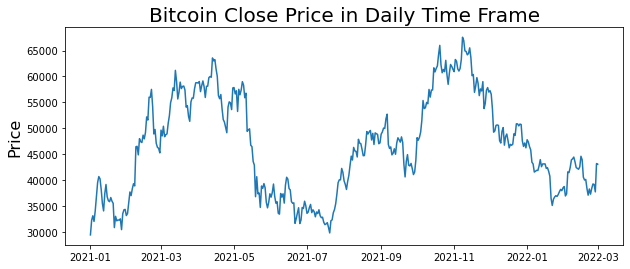

In [74]:
plt.figure(figsize=(10,4))
plt.plot(df_daily["close"])
plt.title('Bitcoin Close Price in Daily Time Frame', fontsize=20)
plt.ylabel('Price', fontsize=16)

<BarContainer object of 26 artists>

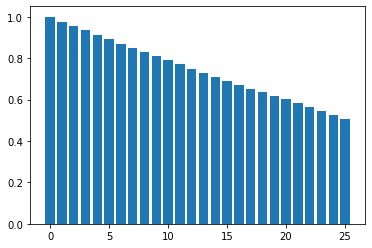

In [75]:
acf_vals = acf(df_daily["close"])
num_lags = 26
plt.bar(range(num_lags), acf_vals[:num_lags])

<BarContainer object of 26 artists>

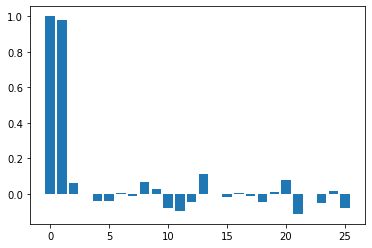

In [76]:
pacf_vals = pacf(df_daily["close"])
num_lags = 26
plt.bar(range(num_lags), pacf_vals[:num_lags])

**To getting better results for acf and pacf we are going to delete trend from data with taking difference in data.**

In [77]:
# deleting trend 
dclose_diff = df_daily["close"].diff()[1:]
dopen_diff = df_daily["open"].diff()[1:]
dhigh_diff = df_daily["high"].diff()[1:]
dlow_diff = df_daily["low"].diff()[1:]
len(dclose_diff)

424

Text(0, 0.5, 'difference')

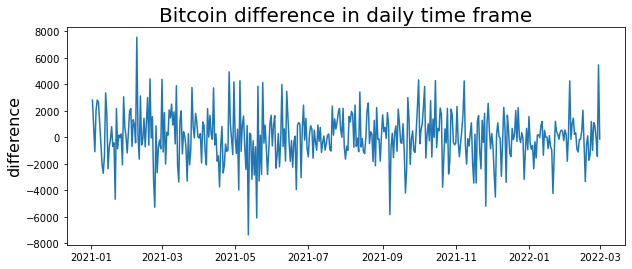

In [80]:
plt.figure(figsize=(10,4))
plt.plot(dclose_diff)
plt.title('Bitcoin difference in daily time frame', fontsize=20)
plt.ylabel('difference', fontsize=16)


<BarContainer object of 26 artists>

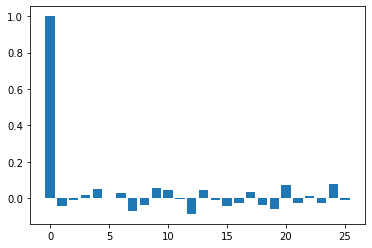

In [81]:
acf_vals = acf(dclose_diff)
num_lags = 26
plt.bar(range(num_lags), acf_vals[:num_lags])

<BarContainer object of 25 artists>

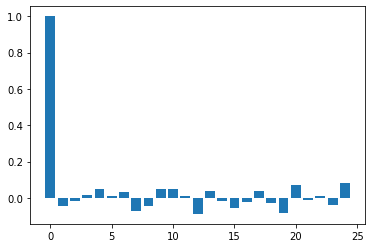

In [82]:
pacf_vals = pacf(dclose_diff)
num_lags = 25
plt.bar(range(num_lags), pacf_vals[:num_lags])

**While acf and pacf are not statistically significant in daily time frame we have to work with higher time frames.**

In [83]:
wclose_diff = df_weekly["close"].diff()[1:]
wopen_diff = df_weekly["open"].diff()[1:]
whigh_diff = df_weekly["high"].diff()[1:]
wlow_diff = df_weekly["low"].diff()[1:]
len(wclose_diff)

61

Text(0, 0.5, 'Difference')

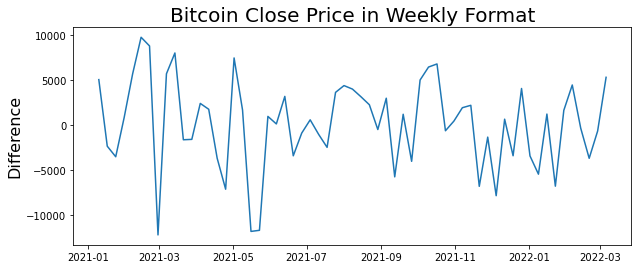

In [84]:
plt.figure(figsize=(10,4))
plt.plot(wclose_diff)
plt.title('Bitcoin Close Price in Weekly Format', fontsize=20)
plt.ylabel('Difference', fontsize=16)

<BarContainer object of 18 artists>

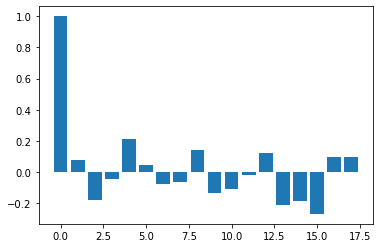

In [85]:
acf_vals = acf(wclose_diff)
num_lags = 18
plt.bar(range(num_lags), acf_vals[:num_lags])

<BarContainer object of 18 artists>

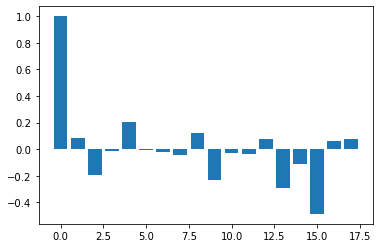

In [86]:
pacf_vals = pacf(wclose_diff)
num_lags = 18
plt.bar(range(num_lags), pacf_vals[:num_lags])

**15th lag is significant enough to get better estimate in both acf and pacf.**
**Also data has a seasonal attribute with to highs, we are going two use Seasonal ARIMA model.**

In [87]:
train_data = df_weekly["close"][:59]
test_data = df_weekly["close"][59:]

**While we take difference from non-seasonal data, our non-seasonal order's Integrated part is equal to 1.**

**AR and MA part will be evaluated in seasonal order. So they are equal to 1 in seasonal order. The frequency of the data is 15 from acf and pacf. So frequency order is equal to 15.**

In [88]:
order = (0, 1, 0)
seasonal_order = (1, 0, 1, 15)
model = SARIMAX(train_data, order=(0, 1, 0), seasonal_order=(1, 0, 1, 15))


In [89]:
#fitting model
model_fit = model.fit()

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [90]:
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data - predictions

Text(0, 0.5, 'Error')

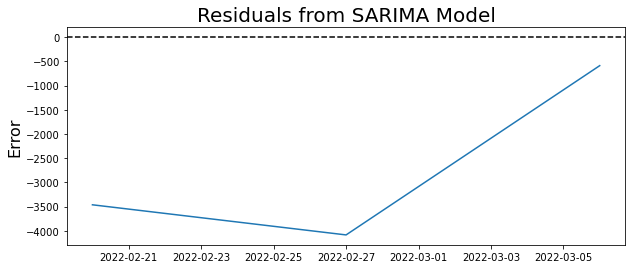

In [91]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

Text(0, 0.5, 'Price')

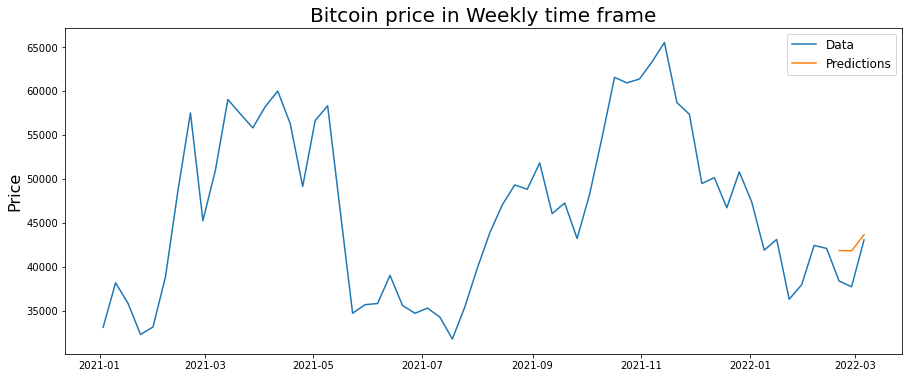

In [94]:
plt.figure(figsize=(15,6))

plt.plot(df_weekly["close"])
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=12)

plt.title('Bitcoin price in Weekly time frame', fontsize=20)
plt.ylabel('Price', fontsize=16)


In [95]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: 0.0708


**We are getting error above %5. So in order to reduce error, we should go with rolling forecast. The job of the rolling forecast is that after making the forecast for the next step, when the data for the next step appears, it adds this data to the train data and makes a more accurate prediction of the next step.**

**For example we have 1 to k train data and we are predicting (k+1)th data. When we learn the value of (k+1), our train data changes from 1 to k+1 to estimate (k+2).**

In [96]:
train_data = df_weekly["close"][:59]
test_data = df_weekly["close"][59:]

In [97]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = df_weekly["close"][:train_end-timedelta(weeks=1)]
    model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [98]:
rolling_residuals = test_data - rolling_predictions

Text(0, 0.5, 'Error')

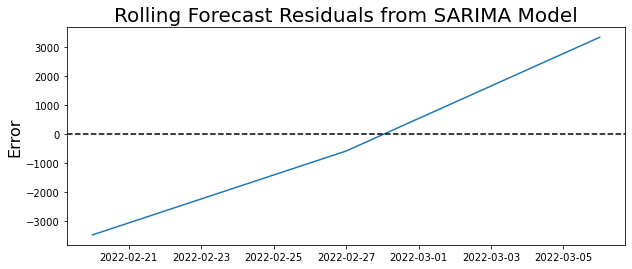

In [99]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

Text(0, 0.5, 'Price')

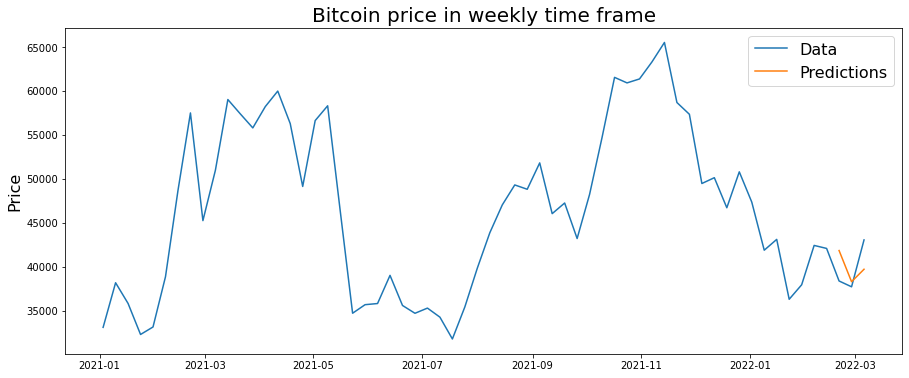

In [107]:
plt.figure(figsize=(15,6))

plt.plot(df_weekly["close"])
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Bitcoin price in weekly time frame', fontsize=20)
plt.ylabel('Price', fontsize=16)


In [108]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data)),4))

Mean Absolute Percent Error: 0.0611


**We were able to lower our error but it's still above 5%. I think because my observations are really low, I couldn't forecast correctly. I am going to add more data.**

In [109]:
df_expand = pd.DataFrame(df_weekly["close"])

df_expand

,close
date,
2021-01-03,33097.83
2021-01-10,38173.73
2021-01-17,35819.25
2021-01-24,32288.83
2021-01-31,33141.38
2021-02-07,38858.39
2021-02-14,48662.50
2021-02-21,57492.91
2021-02-28,45240.96


In [110]:
df_oldval = pd.DataFrame({"date":["2020-1-5","2020-1-12","2020-1-19","2020-1-26","2020-2-2","2020-2-9","2020-2-16","2020-2-23","2020-3-1",
                                 "2020-3-8","2020-3-15","2020-3-22","2020-3-29","2020-4-5","2020-4-12","2020-4-19","2020-4-26","2020-5-3",
                                  "2020-5-10","2020-5-17","2020-5-24","2020-5-31","2020-6-7","2020-6-14","2020-6-21","2020-6-28","2020-7-5",
                                  "2020-7-12","2020-7-19","2020-7-26","2020-8-2","2020-8-9","2020-8-16","2020-8-23","2020-8-30","2020-9-6",
                                  "2020-9-13","2020-9-20","2020-9-27","2020-10-4","2020-10-11","2020-10-18","2020-10-25",
                                  "2020-11-1","2020-11-8","2020-11-15","2020-11-22","2020-11-29","2020-12-6","2020-12-13", 
                                  "2020-12-20", "2020-12-27"],
                    "close":[7358,8185,8701,8615,9331,10151,9917,9936,8531,8033,5361,5816,5881,6772,6903,7120,7693,8894,8722,9681,8718,9448,9747,
                        9350,9294,9116,9069,9303,9209,9931,11071,11681,11910,11648,11711,10256,10333,10920,
                        10774,10666,11369,11503, 13029, 13761, 15475, 15957, 18413, 18185, 19358, 19175, 23455, 26281]})
df_oldval['date'] = pd.to_datetime(df_oldval['date'])

# Set the date column as the index
df_oldval.set_index('date', inplace=True)
new_close = pd.concat([df_oldval,df_expand])
new_close

,close
date,
2020-01-05,7358.00
2020-01-12,8185.00
2020-01-19,8701.00
2020-01-26,8615.00
2020-02-02,9331.00
2020-02-09,10151.00
2020-02-16,9917.00
2020-02-23,9936.00
2020-03-01,8531.00


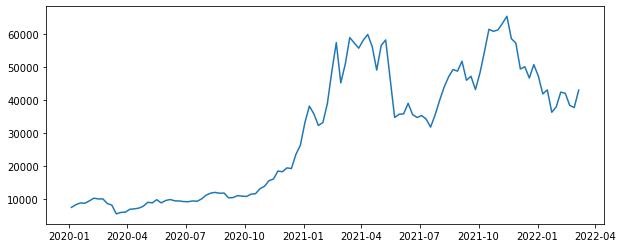

In [126]:
plt.figure(figsize=(10,4))
plt.plot(new_close["close"])
new_close = new_close.asfreq(pd.infer_freq(new_close.index))

In [127]:
new_diff = new_close.diff()[1:]

Text(0, 0.5, 'Difference')

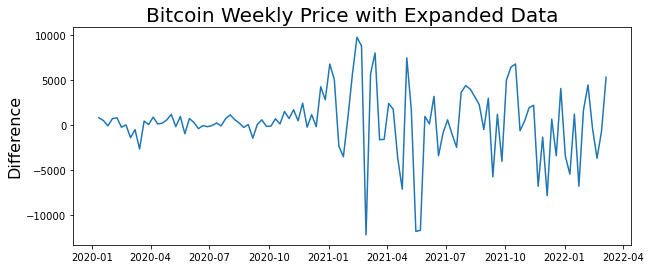

In [128]:
plt.figure(figsize=(10,4))
plt.plot(new_diff)
plt.title('Bitcoin Weekly Price with Expanded Data', fontsize=20)
plt.ylabel('Difference', fontsize=16)

<BarContainer object of 20 artists>

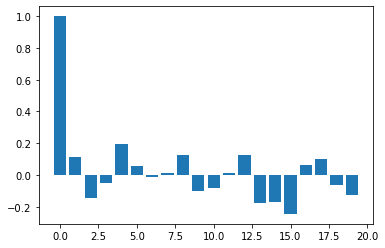

In [129]:
acf_vals = acf(new_diff)
num_lags = 20
plt.bar(range(num_lags), acf_vals[:num_lags])

<BarContainer object of 20 artists>

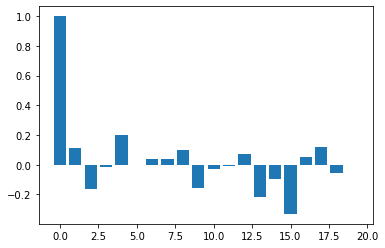

In [130]:
pacf_vals = pacf(new_diff)
num_lags = 20
plt.bar(range(num_lags), pacf_vals[:num_lags])

**Choosing 15 lags is the best option for both acf and pacf. Now our data is better in terms of statistical significance.**

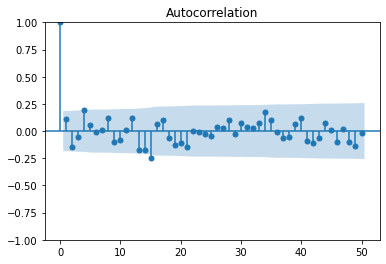

In [131]:
#
import statsmodels.api as sm

# Load the time series data
sm.graphics.tsa.plot_acf(new_diff, lags=50, alpha=0.05)

# Show the plot
plt.show()

C:\Users\user\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


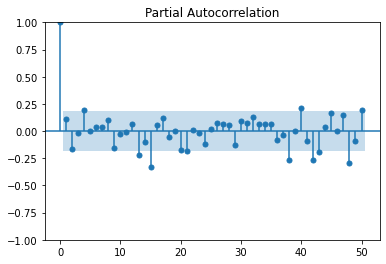

In [148]:
sm.graphics.tsa.plot_pacf(new_diff, lags=50, alpha=0.05)

plt.show()

**As we can see, increasing the number of lags in pacf does not help much, but gives negative results for acf. So 15 lags are enough for us.**

In [149]:
train_data = new_close["close"][25:110]
test_data = new_close["close"][110:]


**Avoiding first 25 values give lower mean absolute error. I noticed when trying manually. The behavior of the price may have changed since then.**

In [150]:
my_order = (0,1,0)
my_seasonal_order = (1, 0, 1, 15)

model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order, freq = "W")

In [151]:
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 0.07881498336791992


In [152]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data - predictions

Text(0, 0.5, 'Error')

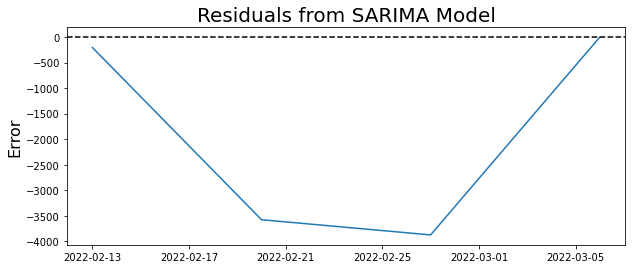

In [153]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

Text(0, 0.5, 'Price')

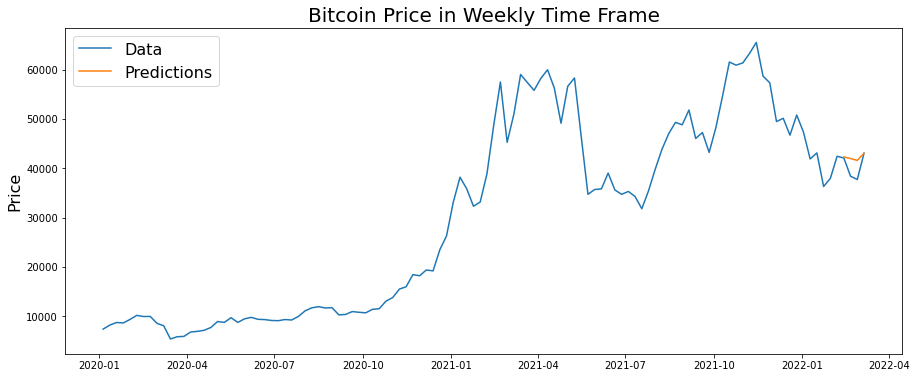

In [154]:
plt.figure(figsize=(15,6))

plt.plot(new_close)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Bitcoin Price in Weekly Time Frame', fontsize=20)
plt.ylabel('Price', fontsize=16)


In [155]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: 0.0503


**We got an almost good result. We can make it better with rolling forecast.**

In [156]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = new_close[:train_end-timedelta(weeks=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

In [157]:
rolling_residuals = test_data - rolling_predictions

Text(0, 0.5, 'Error')

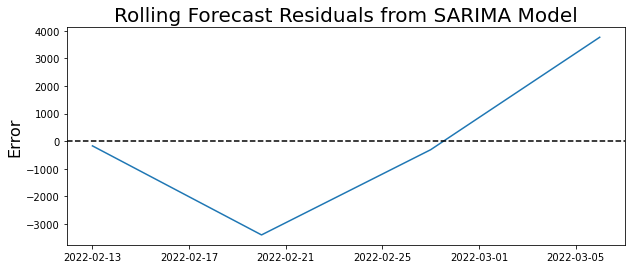

In [158]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

Text(0, 0.5, 'Price')

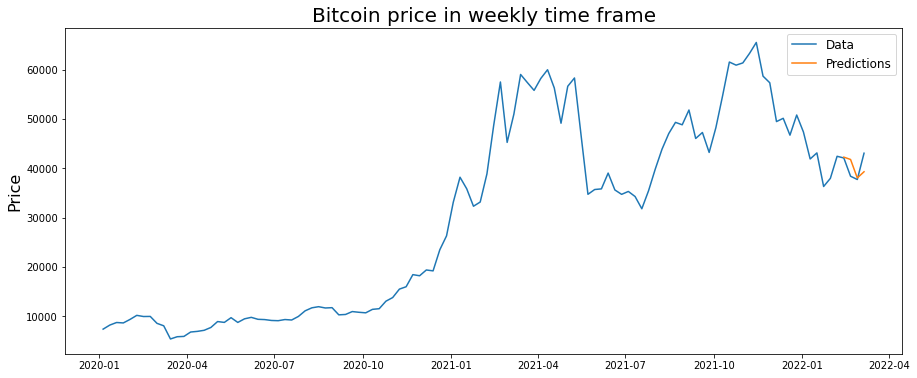

In [159]:
plt.figure(figsize=(15,6))

plt.plot(new_close)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=12)

plt.title('Bitcoin price in weekly time frame', fontsize=20)
plt.ylabel('Price', fontsize=16)

In [160]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data)),4))

Mean Absolute Percent Error: 0.0471


**We were able to get a result below 5%. The similarity of our estimation with the true value also shows us that we got a good result.**

**Our model chooses bias correctly. Also gives opportunity to trade bitcoin.**